# Main working file

In [1]:
# imports

## system
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import util.feature_selection as fs
import util.correlation_measure as cm
import util.validation_testing as val
import util.toolbox as toolbox
import util.visualisation as vis

from scipy.stats import spearmanr  

LOCATION = "data"
ACTION_UNITS = "data/au"
FEATURE_FOLDER = "features"
CORRELATION_FOLDER = 'correlations'
PHASES = [f'{name}_{i}' for name, num in  [("instructional_video", 1), ("discussion_phase", 2), ('reschu_run',8)] for i in range(num)]
SETS = ['corrca', 'factors']
FACTORS = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
COMPONENTS = ['c1', 'c2', 'c3']
PAIRS = [f'0{i}_0{i+1}' for i in np.arange(1,9,2)]
PAIRS.append("09_10")
PAIRS.extend([f'{i}_{i+1}' for i in np.arange(11,104,2)])


AVAILABLE_PAIRS = []
SKIP_PAIRS = ['53_54', '55_56', "63_64", "89_90"]


# make dirs
for file in os.listdir(ACTION_UNITS):
    if ".csv" in file and 'Data' in file: 
        filename = os.path.join(ACTION_UNITS, file)
        participant, _ = file.split("_",1)
        participant = participant[2:]
        for p in PAIRS:
            p1,p2 = p.split("_")
            if participant == p1 or participant == p2:
                pair = p
                break
        if pair in SKIP_PAIRS:
            continue
        if pair not in AVAILABLE_PAIRS:
            AVAILABLE_PAIRS.append(pair)
            dir = os.path.join(LOCATION, pair)
            os.makedirs(dir, exist_ok=True)
            dir = os.path.join(LOCATION, pair, FEATURE_FOLDER)
            os.makedirs(dir, exist_ok=True)
            dir = os.path.join(LOCATION, pair, CORRELATION_FOLDER)
            os.makedirs(dir, exist_ok=True)

print(f"Found {len(AVAILABLE_PAIRS)} available pairs to process.")


Found 44 available pairs to process.


# Feature selection


## Corrca Weights

In [2]:
## CREATING WEIGHTS FOR EACH PAIR SEPARATELY

navigator_df = pd.DataFrame()
pilot_df = pd.DataFrame()

# corrCA takes a df as input. This df should be all files for a pair. 
for pair in AVAILABLE_PAIRS:
    print(f"{pair} is being processed...")
    weights_path = os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv')
    if os.path.exists(weights_path):
        print(f"Already computed corrca weights for {pair}, skipping...")
        continue

    p1, p2 = pair.split("_")
    p1_df = pd.DataFrame()
    p2_df = pd.DataFrame()

    for file in os.listdir(ACTION_UNITS):
        if '.csv' in file and 'Data' in file and p1 in file: 
            df = pd.read_csv(os.path.join(ACTION_UNITS, file))
            p1_df = pd.concat([p1_df, df])
        if '.csv' in file and 'Data' in file and p2 in file: 
            df = pd.read_csv(os.path.join(ACTION_UNITS, file))
            p2_df = pd.concat([p2_df, df])
    if len(p1_df) < 1 or len(p2_df) < 1:
        print(f"Pair {pair} misses either navigator or pilot action unit files, REMOVING FROM AVAILABLE PAIRS...")
        AVAILABLE_PAIRS = [i for i in AVAILABLE_PAIRS if i!=pair]
        continue
    p1_df = p1_df.iloc[:len(p2_df)]
    p2_df = p2_df.iloc[:len(p1_df)]

    mask = (p1_df.isna().any(axis=1).values) | (p2_df.isna().any(axis=1).values)
    p1_df = p1_df[~mask].reset_index(drop=True)
    p2_df = p2_df[~mask].reset_index(drop=True)

    navigator_df = pd.concat([navigator_df, p1_df])
    pilot_df = pd.concat([pilot_df, p2_df])

    w = fs.corrCA_weights(p1_df, p2_df) #output = pair/pair_corrca_weights.csv
    w.to_csv(os.path.join(weights_path), index=False)


if False:
    print(f"Ended with {len(AVAILABLE_PAIRS)} available pairs to process further.")
    
    w = fs.corrCA_weights(navigator_df, pilot_df)
    w.to_csv('data/general_corrca_weights.csv', index=False)

05_06 is being processed...
Already computed corrca weights for 05_06, skipping...
07_08 is being processed...
Already computed corrca weights for 07_08, skipping...
09_10 is being processed...
Already computed corrca weights for 09_10, skipping...
99_100 is being processed...
Already computed corrca weights for 99_100, skipping...
101_102 is being processed...
Already computed corrca weights for 101_102, skipping...
103_104 is being processed...
Already computed corrca weights for 103_104, skipping...
13_14 is being processed...
Already computed corrca weights for 13_14, skipping...
15_16 is being processed...
Pair 15_16 misses either navigator or pilot action unit files, REMOVING FROM AVAILABLE PAIRS...
17_18 is being processed...
Already computed corrca weights for 17_18, skipping...
19_20 is being processed...
Already computed corrca weights for 19_20, skipping...
21_22 is being processed...
Already computed corrca weights for 21_22, skipping...
23_24 is being processed...
Pair 23_

In [2]:
AVAILABLE_PAIRS = ['05_06', '07_08', '09_10', '99_100', '101_102', '103_104', '13_14', '17_18', '19_20', '21_22', '25_26', '27_28', '29_30', '31_32', '33_34', '35_36', '37_38', '39_40', '41_42', '43_44', '45_46', '47_48', '49_50', '51_52', '59_60', '61_62', '65_66', '67_68', '69_70', '71_72', '73_74', '75_76', '77_78', '79_80', '81_82', '83_84', '85_86', '87_88', '91_92', '93_94', '95_96', '97_98']

## Feature extraction: Factors and CorrCA

In [4]:
## EXTRACTING FACIAL FACTORS AND CORRCA FOR EACH FILE SEPARATELY
if False:
    for pair in AVAILABLE_PAIRS:
        print(f"{pair} is being processed...")
        # check whether we can perform corrca
        if not os.path.exists(os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv')):
            print(f"Found no corrca weights for {pair}, skipping corrca components.")    
        else:
            w = pd.read_csv(os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv'))
        
        w_gen = pd.read_csv('data/general_corrca_weights.csv')

        p1, p2 = pair.split("_")
        for phase in PHASES: 
            p1_file = os.path.join(ACTION_UNITS, f"pp{p1}_navigator_{phase}_AU_withMissingData.csv")
            p2_file = os.path.join(ACTION_UNITS, f"pp{p2}_pilot_{phase}_AU_withMissingData.csv")

            if os.path.exists(p1_file) and os.path.exists(p2_file):
                p1_df = pd.read_csv(p1_file)
                p2_df = pd.read_csv(p2_file)

                # make equal length
                p1_df = p1_df.iloc[:len(p2_df)]
                p2_df = p2_df.iloc[:len(p1_df)]

                # remove all missing data
                mask = (p1_df.isna().any(axis=1).values) | (p2_df.isna().any(axis=1).values)
                p1_df = p1_df[~mask].reset_index(drop=True)
                p2_df = p2_df[~mask].reset_index(drop=True)

                p1_factors = fs.au_to_factors(p1_df)
                p1_factors.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p1}_{phase}_factors.csv"), index=False)
                
                p2_factors = fs.au_to_factors(p2_df)
                p2_factors.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p2}_{phase}_factors.csv"), index=False)

                if not os.path.exists(os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv')):
                    continue

                p1_corrca = fs.apply_corrCA_weights(p1_df, w)
                p1_corrca.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p1}_{phase}_corrca.csv"), index=False)

                p2_corrca = fs.apply_corrCA_weights(p2_df, w)
                p2_corrca.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p2}_{phase}_corrca.csv"), index=False)

                p1_gen = fs.apply_corrCA_weights(p1_df, w_gen)
                p1_gen.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p1}_{phase}_global_corrca.csv"), index=False)

                p2_gen = fs.apply_corrCA_weights(p2_df, w_gen)
                p2_gen.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p2}_{phase}_global_corrca.csv"), index=False)
                



# cRQA

In [3]:
scores = pd.read_csv('RESCHU-data/teamscores_allParticipants_filtered.csv')
scores = scores[['SubjectId', 'reschuRun', 'TeamTotal']]

RESCHU_DATA = {}
for pair in AVAILABLE_PAIRS:
    p1, _ = pair.split("_")
    df = scores[scores['SubjectId'] == int(p1)]
    score = [[df['reschuRun'].values[i], df['TeamTotal'].values[i]] for i in range(len(df))]
    RESCHU_DATA[pair] = {
        'score' : score,
        'zoom'  : (int(p1)-1)%4 < 2,
        'beeps' : [int(p1) % 4 == 1, int(p1) % 4 != 1] * 4
    }

# print example RESCHU data
print(f'Example RESCHU data for pair 51_52: \nscore: {RESCHU_DATA['51_52']['score']}\nzoom: {RESCHU_DATA['51_52']['zoom']}\nbeeps: {RESCHU_DATA['51_52']['beeps']}')

Example RESCHU data for pair 51_52: 
score: [[1, 5], [2, 1], [3, 10], [4, 3], [5, 11], [6, 8], [7, 12]]
zoom: False
beeps: [False, True, False, True, False, True, False, True]


## Validation 

In [6]:
# Gridsearch
if False:
    #toolbox.crqa_radius_gridsearch_COMPOUND_GLOBAL("global_compound", radii = [0.001, 0.005, 0.010, 0.015, 0.020, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    df = pd.read_csv('global_compound.csv')
    toolbox.plot_crqa_radius_gridsearch(df, "global_compound")


In [ ]:
# Significance testing
if False: # perform gridsearch for data collection
    radius = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5]
    name = 'only_ccc'
    toolbox.crqa_radius_gridsearch_COMPOUND(name, radius, AVAILABLE_PAIRS=AVAILABLE_PAIRS)
    df = pd.read_csv(f'{name}.csv')
    toolbox.plot_crqa_radius_gridsearch(df, name)

debug = False
if True: # compare significance across partitions
    if debug: print("We are splitting the dataset for including and excluding non-event matches. It does not matter whether combined they are significant.")
    df_results = pd.DataFrame(columns = ['version', 'factor', 'comparison'])
    df = pd.read_csv('results/cRQA_gridsearch_incl_both_compounds.csv')
    if debug: print("For all pairs...")
    df_validation = val.statistical_factor_analysis(df, nem=True) # debug = True for the p_values
    df_significant = df_validation[df_validation['p_fdr'] < 0.05]
    combinations = df_significant[['factor', 'comparison']].drop_duplicates()
    combinations['version'] = 'full'
    df_results = pd.concat([df_results, combinations])
    if debug: print(f"\nRemaining factors are: {combinations}")
    if debug: print('\n')

    if debug: print('\nSEPERATING PHASES!!!\n\n')
    for phase in PHASES:
        if debug: print("phase:", phase)
        df_phase = df[df['phase'] == phase]
        df_validation3 = val.statistical_factor_analysis(df_phase, nem=True) # debug = True for the p_values
        df_significant3 = df_validation3[df_validation3['p_fdr'] < 0.05]
        combinations = df_significant3[['factor', 'comparison']].drop_duplicates()
        combinations['version'] = phase
        df_results = pd.concat([df_results, combinations])
        if debug: print(f"\nRemaining factors are: {combinations}")
    if debug: print('\n')

    rr = []
    condition = []
    component_factor = []
    df1 = pd.DataFrame(columns = ['condition', 'component_factor', 'RR', 'non_event_matches'])
    df2 = pd.DataFrame(columns = ['condition', 'component_factor', 'RR', 'non_event_matches'])
    
    for index, row in df.iterrows():
        if row['condition'] == 'fake':
            df1.loc[len(df1)] = [row['condition'], row['component_factor'], row['RR'], row['non_event_matches']]
            df2.loc[len(df2)] = [row['condition'], row['component_factor'], row['RR'], row['non_event_matches']]
            continue
        pair = row['pair'].split("_")
        pair = pair[0]+ "_" + pair[1]
        zoom = RESCHU_DATA[pair]['zoom']
        if not zoom:
            df1.loc[len(df1)] = [row['condition'], row['component_factor'], row['RR'], row['non_event_matches']]
        else:
            df2.loc[len(df2)] = [row['condition'], row['component_factor'], row['RR'], row['non_event_matches']]

    if debug: print("Isolating pairs with zoom window disabled...")
    df1_validation = val.statistical_factor_analysis(df1, nem=True) # debug = True for the p_values
    df_significant1 = df1_validation[df1_validation['p_fdr'] < 0.05]
    combinations = df_significant1[['factor', 'comparison']].drop_duplicates()
    combinations['version'] = 'no zoom'
    df_results = pd.concat([df_results, combinations])
    if debug: print(f"\nRemaining factors are: {combinations}")


    if debug: print('\n')


    if debug: print("Isolating pairs with zoom window enabled...")
    df2_validation = val.statistical_factor_analysis(df2, nem=True) # debug = True for the p_values
    df_significant2 = df2_validation[df2_validation['p_fdr'] < 0.05]
    combinations = df_significant2[['factor', 'comparison']].drop_duplicates()
    combinations['version'] = 'zoom'
    df_results = pd.concat([df_results, combinations])
    if debug: print(f"\nRemaining factors are: {combinations}")

df_results = df_results.drop_duplicates()
df_results


## Retrieve cRQA

In [ ]:
if False:
    df = pd.read_csv('results/cRQA_gridsearch_RR.csv')
    toolbox.plot_crqa_radius_gridsearch(df, "cRQA_gridsearch_RR")

# SCORES OUT OF RESCHU
scores = pd.read_csv('RESCHU-data/teamscores_allParticipants_filtered.csv')
scores = scores[['SubjectId', 'reschuRun', 'TeamTotal']]

RESCHU_DATA = {}
for pair in AVAILABLE_PAIRS:
    p1, _ = pair.split("_")
    df = scores[scores['SubjectId'] == int(p1)]
    score = [[df['reschuRun'].values[i], df['TeamTotal'].values[i]] for i in range(len(df))]
    RESCHU_DATA[pair] = {
        'score' : score,
        'zoom'  : (int(p1)-1)%4 < 2,
        'beeps' : [int(p1) % 4 == 1, int(p1) % 4 != 1] * 4
    }

# print example RESCHU data
print(f'Example RESCHU data for pair 51_52: \nscore: {RESCHU_DATA['51_52']['score']}\nzoom: {RESCHU_DATA['51_52']['zoom']}\nbeeps: {RESCHU_DATA['51_52']['beeps']}')

# chosen radii that work to get meaningful results: RR = 2-5%
RADIUS = {
    'f1': 0.075,
    'f2': 0.075, 
    'f3': 0.05,
    'f4': 0.05,
    'f5': 0.1,
    'f6': 0.025,

    'c1': 0.025,
    'c2': 0.025,
    'c3': 0.025,

    'compound': 0.1,
    'compound_global': 0.025
}

# we chose whether to include non-event matches based on whether it would improve the data, but significance testing did not show a great increase, thus we chose to include non-event matches
REMOVE_NEM = {
    'f1': 0,
    'f2': 0,
    'f3': 0,
    'f4': 0,
    'f5': 0,
    'f6': 0,
    
    'c1': 0,
    'c2': 0,
    'c3': 0,

    'compound': 0,
    'compound_global' : 0
}

FACTORS = ['f2']


print(TRIAL_ENQUETE['51_52'])
print(STUDY_ENQUETE['51_52'])

Example RESCHU data for pair 51_52: 
score: [[1, 5], [2, 1], [3, 10], [4, 3], [5, 11], [6, 8], [7, 12]]
zoom: False
beeps: [False, True, False, True, False, True, False, True]
{2: 140.0, 3: 179.0, 4: 133.0, 5: 55.0, 6: 174.0, 7: 98.0, 8: 178.0}
{'Cohesion': 11.4, 'Cooperation': 8.666666666666666, 'Empathy': 8.695652173913043}


In [ ]:
full_run = False
if True:
    joined_RR_overall = pd.DataFrame(columns=['pair', 'zoom', 'phase', 'beeps', 'score', *COMPONENTS, 'compound', *FACTORS])
    joined_RR_profile = pd.DataFrame(columns=['pair', 'zoom', 'phase', 'beeps', 'score', 'component', *np.arange(-60,61)])

    for pair in AVAILABLE_PAIRS:
        print(f'{pair} is being processed')

        if not full_run and os.path.exists(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_overall.csv')) and os.path.exists(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_profile.csv')) :
             continue
        p1, p2 = pair.split("_")
        RR_overall = pd.DataFrame(columns=['zoom', 'phase', 'beeps', 'score', *COMPONENTS, 'compound', *FACTORS])
        RR_profile = pd.DataFrame(columns=['zoom', 'phase', 'beeps', 'score', 'component', *np.arange(-60,61)])

        pair_data = RESCHU_DATA[pair]
        zoom = pair_data['zoom']
        files = os.path.join(LOCATION, pair, FEATURE_FOLDER)
        for phase in PHASES:
            nav_file = os.path.join(files,f'pp{p1}_{phase}_corrca.csv')
            pil_file = os.path.join(files,f'pp{p2}_{phase}_corrca.csv')
            if 'reschu' in phase:
                if len(pair_data['score']) > int(phase[-1]):
                    beeps = pair_data['beeps'][int(phase[-1])]
                    score = pair_data['score'][int(phase[-1])][1]
                else:
                    beeps = None
                    score = None
            else: 
                beeps = None
                score = None

            # for RR
            components = []
            if os.path.exists(nav_file) and os.path.exists(pil_file):
                # COMPONENTS: C1 C2 C3
                for c in COMPONENTS:
                    nav = pd.read_csv(nav_file)
                    pil = pd.read_csv(pil_file)

                    corr = cm.crqa_lag_analysis(nav[c].values, pil[c].values, radius=RADIUS[c], remove_non_event_matches=REMOVE_NEM[c])
                    components.append(corr['RR'])

                    RR_profile.loc[len(RR_profile)] = [zoom, phase, beeps, score, c, *corr['rr_profile']]
                    joined_RR_profile.loc[len(joined_RR_profile)] = [pair, zoom, phase, beeps, score,  c, *corr['rr_profile']]
                
                # COMPOUND (C1-3 combined)
                nav['compound'] = nav['c1'] + nav['c2'] + nav['c3']
                pil['compound'] = pil['c1'] + pil['c2'] + pil['c3']
                corr = cm.crqa_lag_analysis(nav['compound'].values, pil['compound'].values, radius=RADIUS['compound'], remove_non_event_matches=REMOVE_NEM['compound'])
                components.append(corr['RR'])

                RR_profile.loc[len(RR_profile)] = [zoom, phase, beeps, score, 'compound', *corr['rr_profile']]
                joined_RR_profile.loc[len(joined_RR_profile)] = [pair, zoom, phase, beeps, score, 'compound', *corr['rr_profile']]

                # FACTORS: F4 F5
                # We assume that the corrca component features cannot be extracted without the factor features also being extracted. 
                nav_file = os.path.join(files,f'pp{p1}_{phase}_factors.csv')
                pil_file = os.path.join(files,f'pp{p2}_{phase}_factors.csv')

                for f in FACTORS:
                    nav = pd.read_csv(nav_file)
                    pil = pd.read_csv(pil_file)

                    fac = cm.crqa_lag_analysis(nav[f].values, pil[f].values, radius=RADIUS[f], remove_non_event_matches=REMOVE_NEM[f])
                    components.append(fac['RR'])

                    RR_profile.loc[len(RR_profile)] = [zoom, phase, beeps, score, f, *fac['rr_profile']]
                    joined_RR_profile.loc[len(joined_RR_profile)] = [pair, zoom, phase, beeps, score, f, *fac['rr_profile']]
                    
                RR_overall.loc[len(RR_overall)] = [zoom, phase, beeps, score, *components]
                joined_RR_overall.loc[len(joined_RR_overall)] = [pair, zoom, phase, beeps, score, *components]
                

        RR_overall.to_csv(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_overall.csv'), index=False)
        RR_profile.to_csv(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_profile.csv'), index=False)
if full_run:
    joined_RR_overall.to_csv(r"results/crqa_RR_overall.csv", index=False)
    joined_RR_profile.to_csv(r"results/crqa_RR_profile.csv", index=False)


# Analysis

In [ ]:
# SCORES OUT OF ENQUETE
## POST TRIAL TEAMWORK ASSESSMENT (per reschu_run)
post_trial = pd.read_csv('RESCHU-data/post_trial_enquete.csv')
post_trial = post_trial[['ParticipantID', 'Trial', 'Teamwork_1']] # TODO: extend if needed to fit more


## POST STUDY COHESION COOPERATION AN DEMPATHY ASSESSMENT
post_study = pd.read_csv('RESCHU-data/post_study_enquete.csv')
post_study['Cohe'] = (post_study['Cohesion_1'] + post_study['Cohesion_2'] + post_study['Cohesion_3'] + post_study['Cohesion_4'] + post_study['Cohesion_5'])/5
post_study['Coop'] = (post_study['Cooperation_1'] + post_study['Cooperation_2'] + post_study['Cooperation_3'] + post_study['Cooperation_4'] + post_study['Cooperation_5'] + post_study['Cooperation_6'] + post_study['Cooperation_7'] + post_study['Cooperation_8'] + post_study['Cooperation_9'])/9
for i in range(2,6):
    post_study['Cohesion_1'] = post_study['Cohesion_1'] + post_study[f'Cohesion_{i}']
post_study['Cohesion_1'] = post_study['Cohesion_1']/5
for i in range(2,10):
    post_study['Cooperation_1'] = post_study['Cooperation_1'] + post_study[f'Cooperation_{i}']
post_study['Cooperation_1'] = post_study['Cooperation_1']/9
for i in range(2,24):
    post_study['Empathy_1'] = post_study['Empathy_1'] + post_study[f'Empathy_{i}']
post_study['Empathy_1'] = post_study['Empathy_1']/23
post_study = post_study[['ParticipantID', 'Cohesion_1', 'Cooperation_1', 'Empathy_1']]



STUDY_ENQUETE = {}
TRIAL_ENQUETE = {}
for pair in AVAILABLE_PAIRS:
    p1, p2 = pair.split("_")
    p1_study = post_study[post_study['ParticipantID']== int(p1)]
    p2_study = post_study[post_study['ParticipantID']== int(p2)]

    p1_trial = post_trial[post_trial['ParticipantID'] == int(p1)]
    p2_trial = post_trial[post_trial['ParticipantID'] == int(p2)]

    trial = {}
    for i in range(1,9):
        p1_t = p1_trial[p1_trial['Trial'] == i]
        p2_t = p2_trial[p2_trial['Trial'] == i]
        if len(p1_t) > 0 and len(p2_t) > 0:
            trial[i] = p1_t['Teamwork_1'].values[0] + p2_t['Teamwork_1'].values[0]
    
    TRIAL_ENQUETE[pair] = trial

    if len(p1_study) > 0 and len(p2_study) > 0:
        STUDY_ENQUETE[pair] = {
            'Cohesion' : p1_study['Cohesion_1'].values[0] + p2_study['Cohesion_1'].values[0],
            'Cooperation' : p1_study['Cooperation_1'].values[0] + p2_study['Cooperation_1'].values[0],
            'Empathy': p1_study['Empathy_1'].values[0] + p2_study['Empathy_1'].values[0]
        }


df = pd.read_csv('results/crqa_RR_overall.csv')

cohesion = []
cooperation = []
empathy = []
teamwork = []
for _, row in df.iterrows():
    if 'reschu' not in row['phase']: 
        teamwork.append(None)
    else:
        phase = int(row['phase'][-1]) + 1
        if phase in TRIAL_ENQUETE[row['pair']]:
            teamwork.append(TRIAL_ENQUETE[row['pair']][phase])
        else:
            teamwork.append(None)

    if row['pair'] in STUDY_ENQUETE:
        dic = STUDY_ENQUETE[row['pair']]
        cohesion.append(dic['Cohesion'])
        cooperation.append(dic['Cooperation'])
        empathy.append(dic['Empathy'])
    else:
        cohesion.append(None)
        cooperation.append(None)
        empathy.append(None)

df['Teamwork'] = teamwork
df['Cohesion'] = cohesion
df['Cooperation'] = cooperation
df['Empathy'] = empathy
df.head()

df.to_csv('results/cRQA_RR_overall_with_questionnaire_data.csv')

COMPONENTS = ['c1', 'c2', 'c3', 'compound', 'f2']

## Comparing RR with dependent variables
 (objective) score; 

 (subjective) teamwork, cohesion, cooperation, empathy

In [ ]:
df = pd.read_csv('results/cRQA_RR_overall_with_questionnaire_data.csv')

# Run tests for each dependent variable
for dep_var in ['score', 'Teamwork', 'Cohesion', 'Cooperation', 'Empathy']:
    print(f"\n{'-'*20}\n{dep_var.upper()}\n{'-'*20}")
    avg_results, phase_results = val.run_significance_tests(df, dep_var)
    
    print("Average:")
    print(avg_results)
    print("\nExcluding intro + discussion. \nInspecting phases individually:")
    print(phase_results)


--------------------
SCORE
--------------------
Average:
       setting component       rho         p
0   all_phases        f2 -0.320068  0.038792
1  zoom = True        c1 -0.446640  0.037177

Excluding intro + discussion. 
Inspecting phases individually:
        setting component       rho         p
0   zoom = True        c1 -0.294160  0.000715
1   zoom = True        c3 -0.201299  0.022164
2   zoom = True  compound -0.309158  0.000364
3  reschu_run_7        f2 -0.476815  0.045425

--------------------
TEAMWORK
--------------------
Average:
        setting component       rho         p
0    all_phases        f2  0.419095  0.006385
1  zoom = False        f2  0.459649  0.047708

Excluding intro + discussion. 
Inspecting phases individually:
        setting component       rho         p
0    all_reschu        f2  0.223789  0.002137
1   zoom = True        f2  0.276191  0.004345
2  zoom = False        c3  0.262895  0.017733
3  reschu_run_5        f2  0.532636  0.010708

-------------------

## delay analysis

Data columns: 121, Expected: 121
Condition 1 mean: 0.059
Condition 2 mean: 0.040
Condition 3 mean: 0.054
Data columns: 121, Expected: 121
Condition 1 mean: 0.069
Condition 2 mean: 0.040
Condition 3 mean: 0.076
6


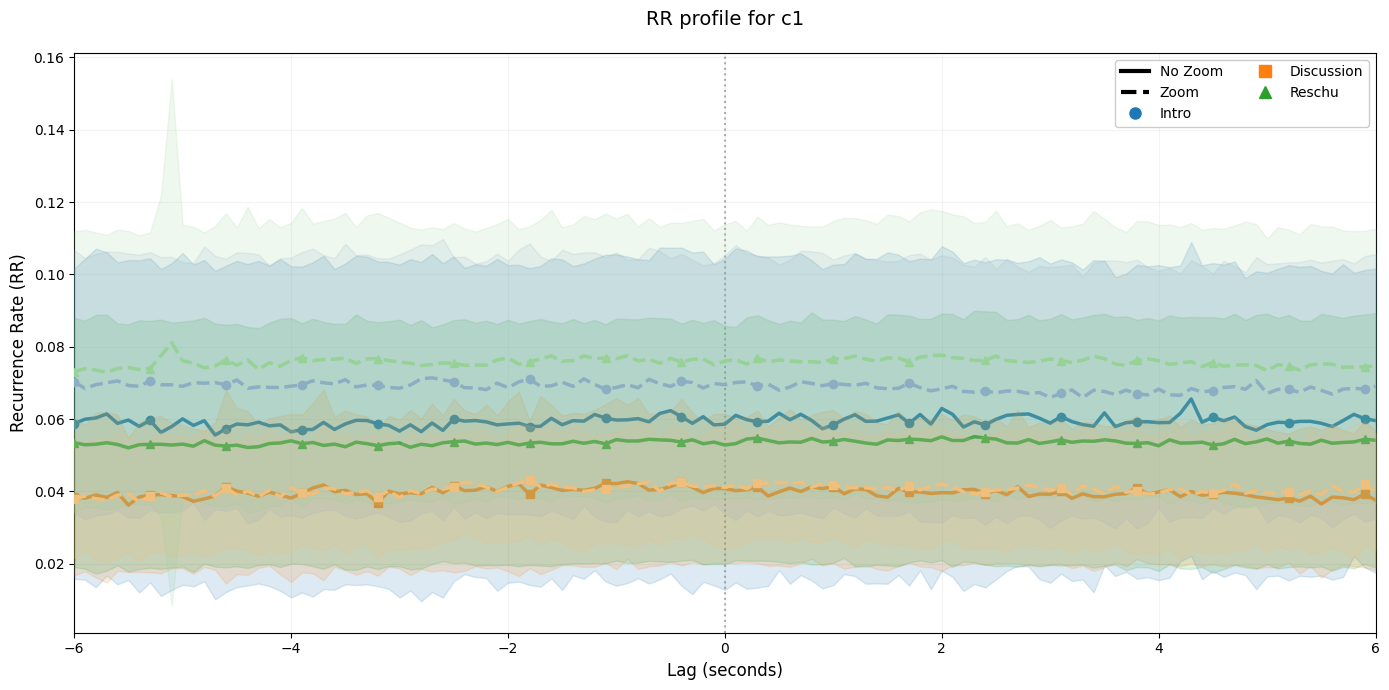

Data columns: 121, Expected: 121
Condition 1 mean: 0.072
Condition 2 mean: 0.045
Condition 3 mean: 0.067
Data columns: 121, Expected: 121
Condition 1 mean: 0.053
Condition 2 mean: 0.039
Condition 3 mean: 0.068
6


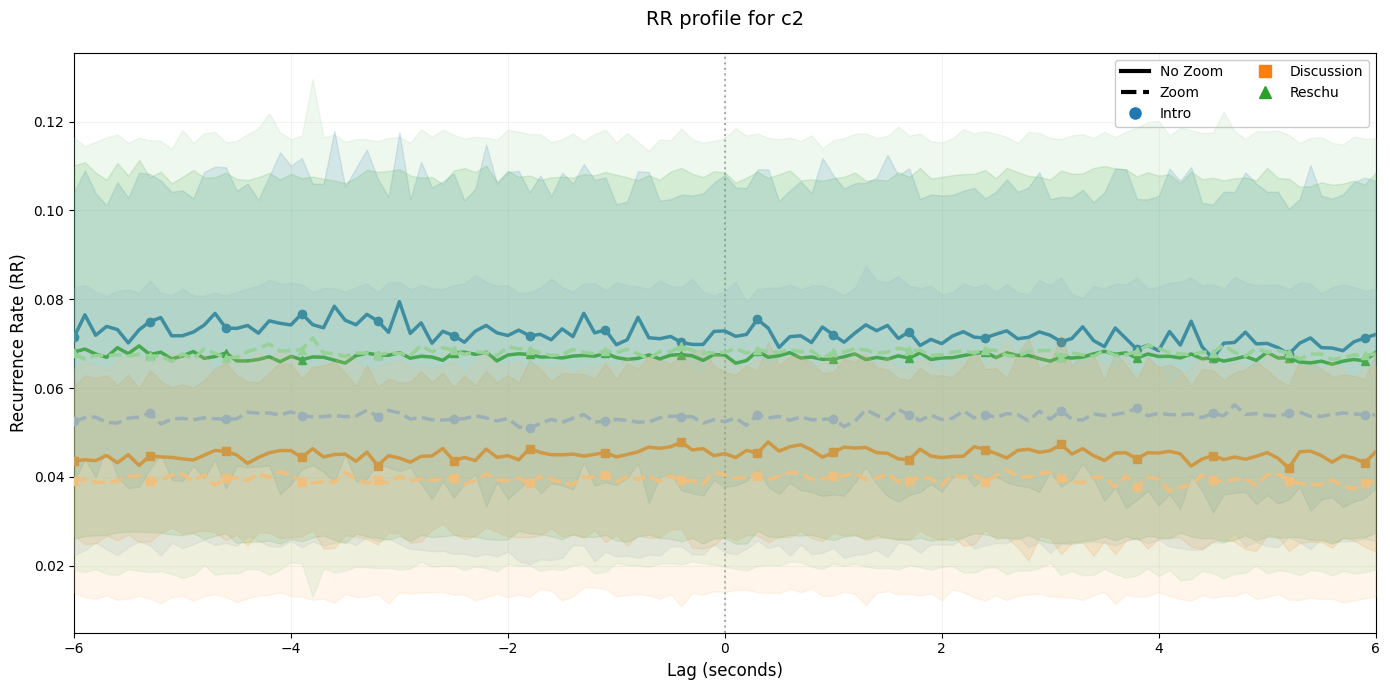

Data columns: 121, Expected: 121
Condition 1 mean: 0.050
Condition 2 mean: 0.039
Condition 3 mean: 0.059
Data columns: 121, Expected: 121
Condition 1 mean: 0.049
Condition 2 mean: 0.038
Condition 3 mean: 0.058
6


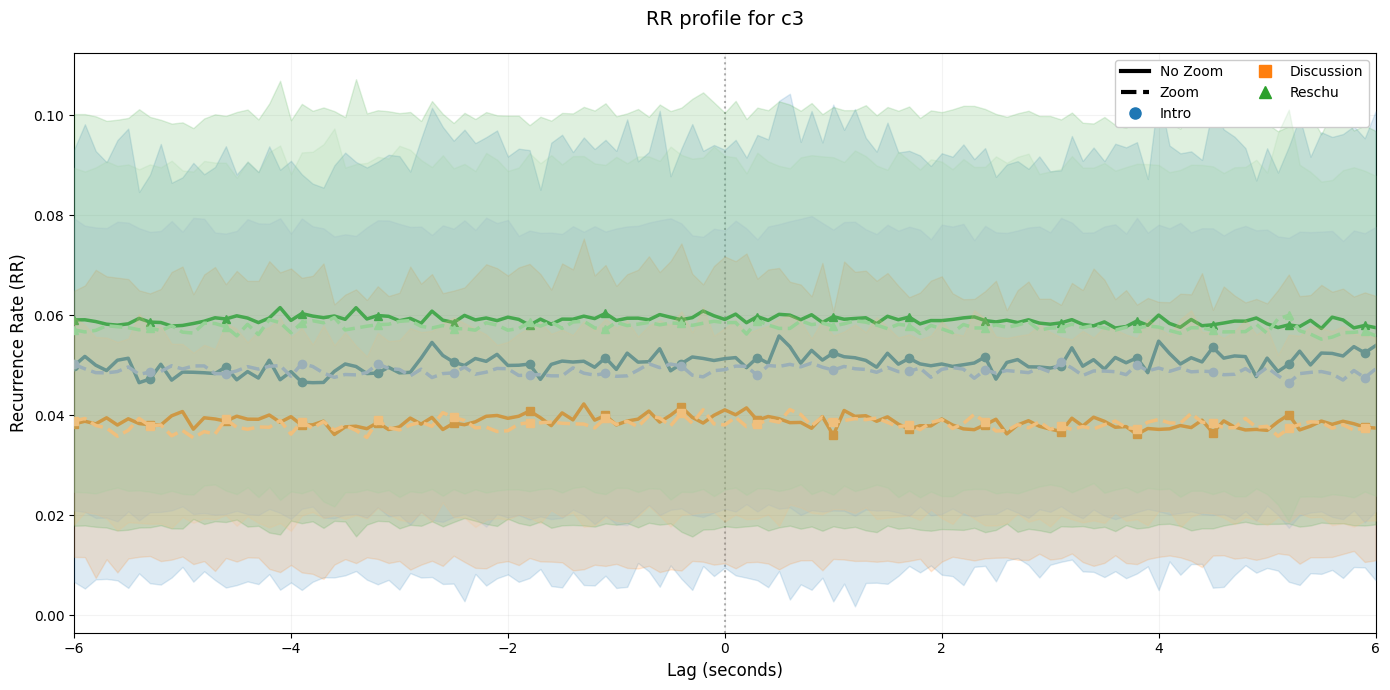

Data columns: 121, Expected: 121
Condition 1 mean: 0.125
Condition 2 mean: 0.093
Condition 3 mean: 0.145
Data columns: 121, Expected: 121
Condition 1 mean: 0.144
Condition 2 mean: 0.093
Condition 3 mean: 0.151
6


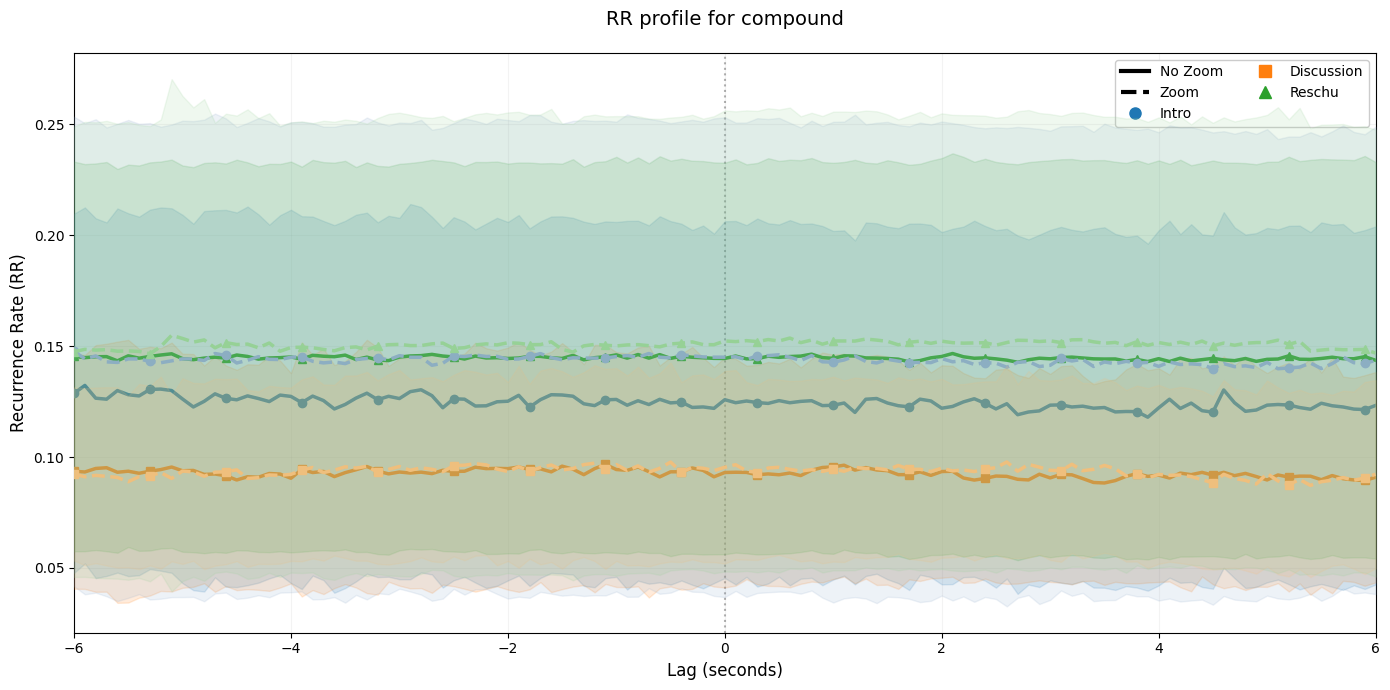

Data columns: 121, Expected: 121
Condition 1 mean: 0.364
Condition 2 mean: 0.324
Condition 3 mean: 0.352
Data columns: 121, Expected: 121
Condition 1 mean: 0.323
Condition 2 mean: 0.295
Condition 3 mean: 0.353
6


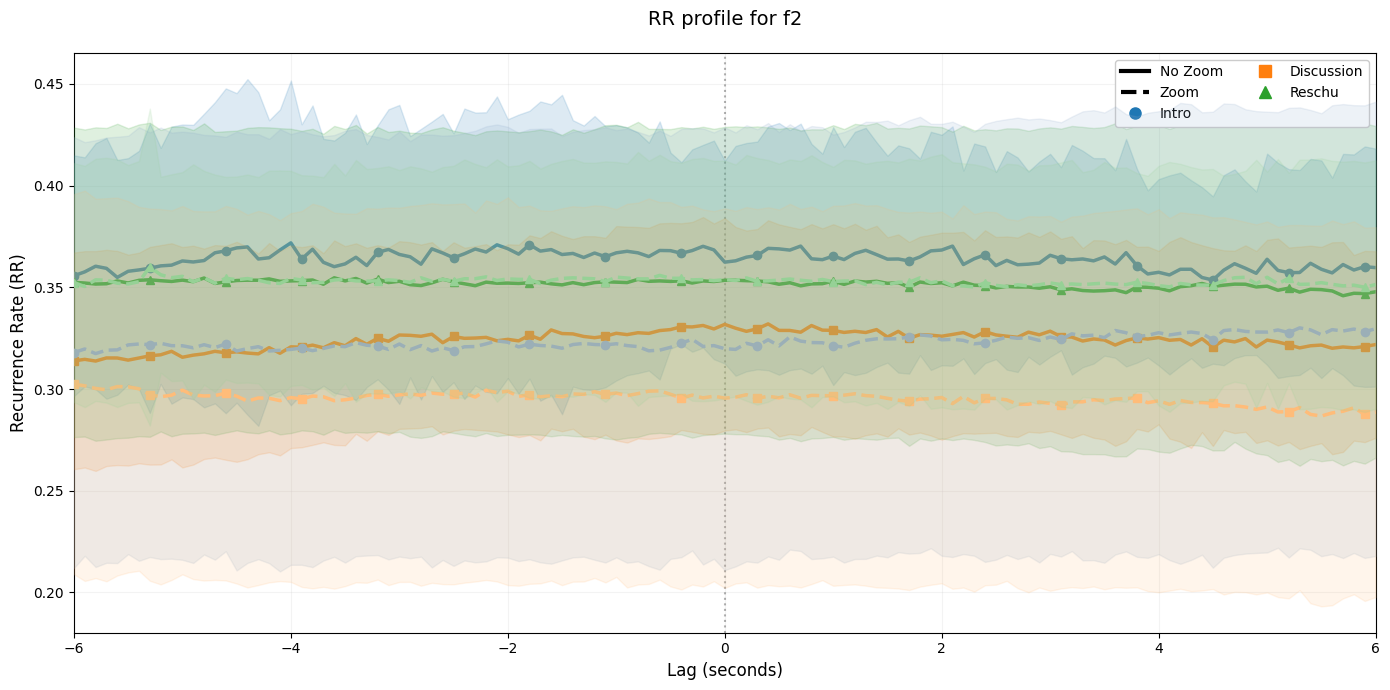

In [ ]:
for c in COMPONENTS:
    # Load and prepare data
    df = pd.read_csv('results/crqa_RR_profile.csv')
    df = df[df['component'] == c]
    # Create condition DataFrames
    df_intro = df[df['phase'] == 'instructional_video_0']
    df_discussion = pd.concat([
        df[df['phase'] == 'discussion_phase_0'], 
        df[df['phase'] == 'discussion_phase_1']
    ])
    df_reschu = pd.concat([
        df[df['phase'] == f'reschu_run_{i}'] 
        for i in range(8)
    ])
    conditions = []
    for zoom in [True, False]:
        df_intro_f = df_intro[df_intro['zoom'] == zoom]
        df_discussion_f = df_discussion[df_discussion['zoom'] == zoom]
        df_reschu_f = df_reschu[df_reschu['zoom'] == zoom]

        # Drop unnecessary columns - make sure these columns exist
        cols_to_drop = ['pair', 'zoom', 'phase', 'beeps', 'score', 'component']
        df_intro_f = df_intro_f.drop(columns=[col for col in cols_to_drop if col in df_intro_f.columns])
        df_discussion_f = df_discussion_f.drop(columns=[col for col in cols_to_drop if col in df_discussion_f.columns])
        df_reschu_f = df_reschu_f.drop(columns=[col for col in cols_to_drop if col in df_reschu_f.columns])

        # Create lag values (-6 to +6 seconds at 10Hz)
        n_lags = 121  # 6*10*2 + 1 (including 0)
        lags = np.linspace(-6, 6, n_lags)

        # Verify data shape matches expected lags
        print(f"Data columns: {df_intro_f.shape[1]}, Expected: {n_lags}")
        assert df_intro_f.shape[1] == n_lags, "Number of columns doesn't match expected lag points!"

        # Convert to list of RR profiles (each row becomes one profile)
        cond1 = [row for row in df_intro_f.values]
        cond2 = [row for row in df_discussion_f.values]
        cond3 = [row for row in df_reschu_f.values]

        # Normalize all conditions to center around 0.
        #cond1, cond2, cond3 = vis.center_conditions([cond1, cond2, cond3])

        # Verify normalization
        for i, cond in enumerate([cond1,cond2,cond3]):
            print(f"Condition {i+1} mean: {np.mean(np.concatenate(cond)):.3f}")
        conditions.append(cond1)
        conditions.append(cond2)
        conditions.append(cond3)

    print(len(conditions))
    # Plot with normalized data
    vis.plot_multicondition_rr_profiles(
        condition_data=conditions,
        lags=lags,
        title=f'RR profile for {c}'
    )